# **Interactive notebook accompanying the paper**

**Coupled sliding-decohesion-compression model for consistent description of monotonic and fatigue behavior of material interfaces (CMAME 2022)**

Chudoba, R., Vořechovský, M., Aguilar, M., Baktheer, A.

This notebook explains the derivation of the interface model based on the thermodynamic 
principles using a `CAS` system. It shows how to obtain the time-stepping algorithm 
directly from the specification of the thermodynamic potentials, i.e. the Helmholtz 
free energy, threshold function and flow potential.

<div style="background-color:lightblue;text-align:center"> 
To execute the code in a cell, press [Shift+Enter]. By executing the cells one-by-one starting from top and reading the annotation of the steps between executable cells, you will be able to follow the abstract thermodynamic derivation leading to an executable simulation code.
</div>

The abstract implementation of the return mapping algorithm for general 
damage-plasticity modes. The basic ingredients of of a thermodynamically based model
are introduced as

 - Vector of state variables $\boldsymbol{\mathcal{E}}$
 - Vector of thermodynamic streses $\boldsymbol{\mathcal{S}}$
 - Helmholtz free energy $\psi(\boldsymbol{\mathcal{E}})$
 - Threshold on thermodynamical forces  $f(\boldsymbol{\mathcal{S}},\boldsymbol{\mathcal{E}})$ / Yield condition
 - Flow potential $\varphi(\boldsymbol{\mathcal{S}},\boldsymbol{\mathcal{E}})$

Based on the symbolic formulation using the `sympy` package, the time-stepping algorithm
is generated automatically by requiring the consistency condition to hold for each 
prescribed load increment.

**Scientific computing in Python**: The Jupyter notebook is executed in a `Python environment` that can be automatically installed using the `conda` package manager. The list of required package is specified [here](../environment.yml). In the subsequent derivation and demonstration, following three packages are used:
 1. Computer algebra is implemented using the `sympy` package ([https://www.sympy.org](https://www.sympy.org)).
 2. The derived expressions are transformed to an executable Python code in terms of `numpy` - a multi-dimensional array package ([https://www.numpy.org](https://www.numpy.org)). 
 3. Plotting of simulation results is done using the `matplotlib` package ([https://www.matplotlib.org](https://www.matplotlib.org)). 

In [1]:
%matplotlib widget 
import sympy as sp # CAS used for symbolic derivations 
sp.init_printing()
import matplotlib.pyplot as plt # plotting package
from matplotlib import cm # color maps for plotting
from sympy.utilities.codegen import codegen # code generation package
import numpy as np # array based numerical package 
np.seterr(divide='ignore', invalid='ignore') # suppress warnings on division by zero
from cymbol import Cymbol, ccode # Symbol class 
from sympy import Heaviside

**From expressions to executable code**: The transformation of the algebraic expressions, vectors and matrices into an executable code is done in two ways. For direct quantitative demonstration of the derived algorithm, the executable `Python` code is obtained using the `numpy.lambdify` method. To show how to transform the code into executable `C` code, at the end of the notebook, the `sympy` subpackage `codegen` is applied. To enable both pretty printing of symbolic expressions and `C` language naming of the variables, the standard `sympy` class called `sympy.Symbol` is overloaded by an own subclass named `Cymbol` that makes it possible to provide the attribute named `codename` for the `C` code generator autonomosly. 

**Heaviside and Dirac delta functions**: Starting with `sympy` 1.9, Heaviside function can be correctly handled
in the `lambdified` code. However, `DiracDelta` function is still not available in the printer. Therefore, a dummy
`get_dirac_delta` is added here as a workaround.

In [2]:
H = Heaviside
def get_dirac_delta(x):
    return 0
numpy_dirac =[{'DiracDelta': get_dirac_delta }, 'numpy']

&nbsp;<font color='blue'>
**Naming conventions:**
 - Python language convention using lowercase letters separated by underscores is used for the variable and function names.
 - Variables with trailing underscore (e.g. `f_`, or `Sig_`) denote `sympy` expressions. 
 - Variables denoting `sympy` symbols (e.g. `Sig` have no underscore at the end and have a name which is close to the mathematical symbol
 - Mathematical symbols defined as string in `Cymbol(r'\tau^{\pi}')` use `latex` syntax to introduce Greek symbols, super and subindexes. This makes the pretty printing of expression possible.

# **1 Symbolic derivation of thermodynamic potentials**

**Include the notebook with the derived threshold function**

The derivation of the continuous and smooth threshold function combining the elliptical capps in the tension and compression with the linear part in the tangential direction is derived in a separate notebook. 
To prepare the symbols for all material parameters, we include the derivation here using the `%run` command. The `%%capture` magic command is used to supress any printing and plotting done in the executed notebook.  
[threshold_function.ipynb](threshold_function.ipynb)

In [3]:
%%capture
%run threshold_function.ipynb

## **1.1 Free energy potential, state variables and thermodynamic forces**

### Material parameters

In [4]:
E_T = Cymbol(r'E_{\mathrm{T}}', codename='E_T_', real=True, nonnegative=True)
gamma_T = Cymbol(r'\gamma_{\mathrm{T}}', codename='gamma_T_', real=True)
K_T = Cymbol(r'K_{\mathrm{T}}', codename='K_T_', real=True)
S_T = Cymbol(r'S_{\mathrm{T}}', codename='S_T_', real=True, nonnegative=True)
r_T = Cymbol(r'r_{\mathrm{T}}', codename='r_T_', real=True, nonnegative=True)
c_T = Cymbol(r'c_{\mathrm{T}}', codename='c_T_', real=True, nonnegative=True)

E_N = Cymbol(r'E_{\mathrm{N}}', codename='E_N_', real=True, nonnegative=True)
gamma_N = Cymbol(r'\gamma_{\mathrm{N}}', codename='gamma_N_', real=True)
S_N = Cymbol(r'S_{\mathrm{N}}', codename='S_N_', real=True, nonnegative=True)
r_N = Cymbol(r'r_{\mathrm{N}}', codename='r_N_', real=True, nonnegative=True)
c_N = Cymbol(r'c_{\mathrm{N}}', codename='c_N_', real=True, nonnegative=True)

eta = Cymbol('eta', codename='eta_', real=True, nonnegative=True)

In [5]:
sp_vars = (E_T, gamma_T, K_T, S_T, c_T, f_s, E_N, gamma_N, S_N, c_N, m, f_t, f_c, f_c0, 
           r_N, r_T, eta)
sp_vars

### State variables

In [6]:
u_Tx = Cymbol(r'u_{\mathrm{T}x}', codename='u_Tx_', real=True)
u_Ty = Cymbol(r',u_{\mathrm{T}y}', codename='u_Ty_', real=True)
u_p_Tx = Cymbol(r'u^{\mathrm{p}}_{\mathrm{T}x}', codename='u_p_Tx_', real=True)
u_p_Ty = Cymbol(r'u^{\mathrm{p}}_{\mathrm{T}y}', codename='u_p_Ty_', real=True)
omega_T = Cymbol(r'\omega_{\mathrm{T}}', codename='omega_T_', real=True, nonnegative=True)
alpha_Tx = Cymbol(r'\alpha_{\mathrm{T}x}', codename='alpha_Tx_', real=True)
alpha_Ty = Cymbol(r'\alpha_{\mathrm{T}y}', codename='alpha_Ty_', real=True)
z_T = Cymbol(r'z_\mathrm{T}', codename='z_T_', real=True)
u_N = Cymbol(r'u_\mathrm{N}', codename='u_N_', real=True)
omega_N = Cymbol(r'\omega_\mathrm{N}', codename='omega_N_', real=True, nonnegative=True)
u_p_N = Cymbol(r'u^{\mathrm{p}}_\mathrm{N}', codename='u_p_N_', real=True)

In [7]:
Eps = sp.Matrix([u_p_Tx, u_p_Ty, u_p_N, z_T, alpha_Tx, alpha_Ty, omega_T, omega_N])
Eps.T

### Helmholtz free energy

The starting point in the thermodynamical representation of a process is a potential function of time dependent state variables. To describe the evolution of the state correctly describing the energy dissipation of the system the gradient of the potential function with respect to the state variables provides the generalized forces. The forces are constrained to characterize specific material properties, e.g. strength, hardening.

In [8]:
sigma_Tx = Cymbol(r'\sigma_{\mathrm{T}x}', codename='sigma_Tx_', real=True)
sigma_Ty = Cymbol(r'\sigma_{\mathrm{T}y}', codename='sigma_Ty_', real=True)
sigma_p_Tx = Cymbol(r'\sigma^\mathrm{p}_{\mathrm{T}x}', codename='sigma_p_Tx_', real=True)
sigma_p_Ty = Cymbol(r'\sigma^\mathrm{p}_{\mathrm{T}y}', codename='sigma_p_Ty_', real=True)
X_Tx = Cymbol(r'X_{\mathrm{T}x}', codename='X_Tx_', real=True)
X_Ty = Cymbol(r'X_{\mathrm{T}x}', codename='X_Ty_', real=True)
Z_T = Cymbol(r'Z_\mathrm{T}', codename='Z_T_', real=True, nonnegative=True)
Y_T = Cymbol(r'Y_\mathrm{T}', codename='Y_T_', real=True, nonnegative=True)
sigma_N = Cymbol(r'\sigma_\mathrm{N}', codename='sigma_N_', real=True)
sigma_p_N = Cymbol(r'\sigma^{\mathrm{p}}_\mathrm{N}', codename='sigma_p_N_', real=True)
Y_N = Cymbol(r'Y_\mathrm{N}', codename='Y_N_', real=True, nonnegative=True)

In [9]:
rho_psi_T_ = sp.Rational(1, 2) * ( 
    (1-omega_T)*E_T*(u_Tx-u_p_Tx)**2 + 
    (1-omega_T)*E_T*(u_Ty-u_p_Ty)**2 + 
    K_T * z_T**2 + 
    gamma_T * alpha_Tx**2 +
    gamma_T * alpha_Ty**2
)

rho_psi_N_ = sp.Rational(1, 2) * (
    (1 - H(sigma_p_N) * omega_N) * E_N * (u_N - u_p_N)**2
)

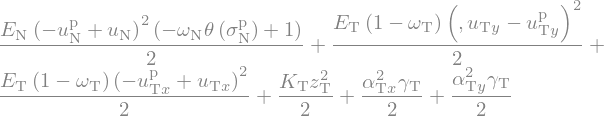

In [10]:
rho_psi_ = rho_psi_T_ + rho_psi_N_
rho_psi_

### Thermodynamic forces

In [11]:
Sig = sp.Matrix([sigma_p_Tx, sigma_p_Ty, sigma_p_N, Z_T, X_Tx, X_Ty, Y_T, Y_N])
Sig.T

The introduce the thermodynamic forces we have to differentiate Hemholtz free energy
with respect to the kinematic state variables
\begin{align}
\frac{\partial \rho \psi }{\partial \boldsymbol{\mathcal{E}}}
\end{align}

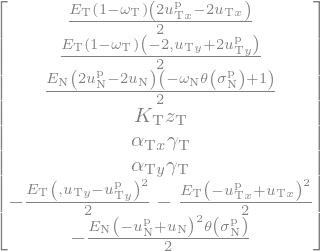

In [12]:
d_rho_psi_ = sp.Matrix([rho_psi_.diff(eps) for eps in Eps])
d_rho_psi_

To obtain consistent signs of the Helmholtz derivatives we define a sign switch operator so that all generalized forces are defined as positive for the respective conjugate state variable $\boldsymbol{\Upsilon}$. 

In [13]:
Sig_signs = sp.diag(-1, -1, -1, 1, 1, 1, -1, -1)

The constitutive laws between generalized force and kinematic variables then read
\begin{align}
\boldsymbol{\mathcal{S}} = \boldsymbol{\Upsilon}\frac{\rho \psi}{\partial\boldsymbol{\mathcal{E}}} 
\end{align}

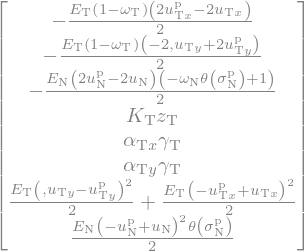

In [14]:
Sig_ = Sig_signs * d_rho_psi_
Sig_

**Executable code for** $\boldsymbol{\mathcal{S}}(s,\boldsymbol{\mathcal{E}})$

Generate the executable code in `Python` and `C` languages.

In [15]:
get_Sig = sp.lambdify( 
    (u_Tx, u_Ty, u_N, Sig, Eps) + sp_vars + ('**kw',), Sig_.T, numpy_dirac
)
get_Sig_C = ccode('get_Sig',Sig_,'SLIDE3_4')

To derive the time stepping procedure we will need also the matrix of derivatives of the generalized stresses $\boldsymbol{\mathcal{S}}$ with respect to the kinematic variables $\boldsymbol{\mathcal{E}}$ 
\begin{align}
\frac{\partial \boldsymbol{S}}{\partial \boldsymbol{E}}
\end{align}

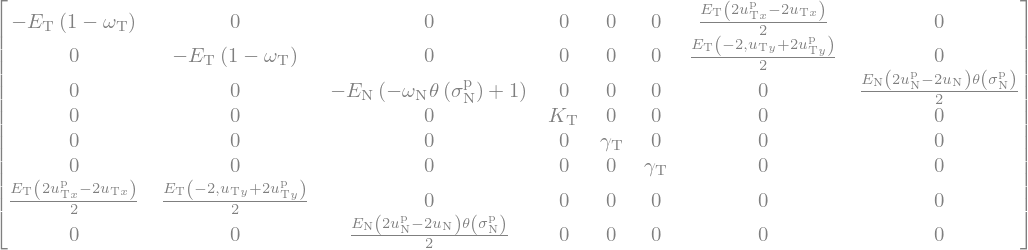

In [16]:
dSig_dEps_ = sp.Matrix([
    Sig_.T.diff(eps) for eps in Eps 
]).T
dSig_dEps_

**Executable Python code generation** $\displaystyle \frac{\partial }{\partial \boldsymbol{\mathcal{E}}}  \boldsymbol{\mathcal{S}}(s,\boldsymbol{\mathcal{E}})$

In [17]:
get_dSig_dEps = sp.lambdify(
    (u_Tx, u_Ty, u_N, Sig, Eps) + sp_vars + ('**kw',), dSig_dEps_, numpy_dirac
)
get_dSig_dEps_C = ccode('get_dSig_dEps', dSig_dEps_, 'SLIDE3_4')

## **1.2 Threshold function**

To keep the framework general for different stress norms and hardening definitions let us first introduce a general function for effective stress. Note that the observable stress $\tau$ is identical with the plastic stress $\tau_\pi$ due to the performed sign switch in the definition of the thermodynamic forces.

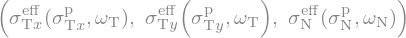

In [18]:
sigma_eff_Tx = sp.Function(r'\sigma^{\mathrm{eff}}_{\mathrm{T}x}')(sigma_p_Tx, omega_T)
sigma_eff_Ty = sp.Function(r'\sigma^{\mathrm{eff}}_{\mathrm{T}y}')(sigma_p_Ty, omega_T)
sigma_eff_N = sp.Function(r'\sigma^{\mathrm{eff}}_{\mathrm{N}}')(sigma_p_N, omega_N)
q_Tx = sp.Function(r'q_Tx')(sigma_eff_Tx,X_Tx)
q_Ty = sp.Function(r'q_Ty')(sigma_eff_Ty,X_Ty)
q_N = sp.Function(r'q_N')(sigma_eff_N)
sigma_eff_Tx, sigma_eff_Ty, sigma_eff_N

The stress norm is defined using the stress offset $X$, i.e. the kinematic hardening stress representing the shift of the origin of the yield locus.  

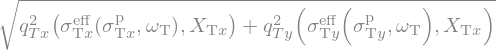

In [19]:
norm_q_T = sp.sqrt(q_Tx*q_Tx + q_Ty*q_Ty)
norm_q_T

Let us now introduce the back stress $X$ by defining the substitution for $Q = \tau^\mathrm{eff} - X$

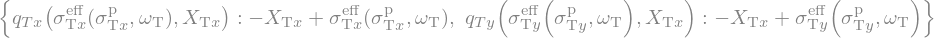

In [20]:
subs_q_T = {q_Tx: (sigma_eff_Tx - X_Tx), q_Ty: (sigma_eff_Ty - X_Ty)}
subs_q_T

In [21]:
subs_q_N = {q_N: sigma_eff_N}
subs_q_N

Further substitution rule introduces the effective stress as a function of damage as

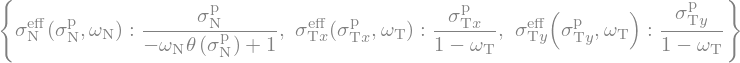

In [22]:
subs_sigma_eff = {sigma_eff_Tx: sigma_p_Tx / (1-omega_T),
                  sigma_eff_Ty: sigma_p_Ty / (1-omega_T),
                  sigma_eff_N: sigma_p_N / (1-H(sigma_p_N)*omega_N)
                 }
subs_sigma_eff

After substitutions the yield function reads

**Smooth yield function**

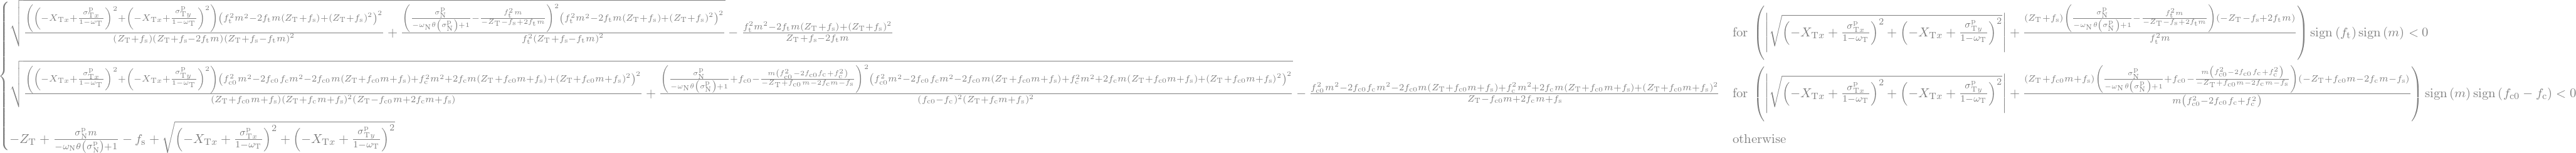

In [23]:
f_ = (f_solved_
      .subs({x: q_N, y: norm_q_T})
      .subs(subs_q_T)
      .subs(subs_q_N)
      .subs(subs_sigma_eff)
      .subs(f_s, (f_s+Z_T))
     )
f_

**Executable code generation** $f(\boldsymbol{\mathcal{E}}, \boldsymbol{\mathcal{S}})$

Note that this is a function of both the forces and kinematic state variables

In [24]:
get_f = sp.lambdify(
    (Eps, Sig) + sp_vars + ('**kw',), f_, numpy_dirac
)
get_f_C = ccode('get_f', f_, 'SLIDE3_4')

The derivative of $f$ required for time-stepping $\frac{\partial f}{\partial \boldsymbol{\mathcal{S}}}$ is obtained as

In [25]:
df_dSig_ = f_.diff(Sig)
# df_dSig_.T

**Executable code generation** $\displaystyle \frac{\partial f}{\partial \boldsymbol{\mathcal{S}}}(\boldsymbol{\mathcal{E}}, \boldsymbol{\mathcal{S})}$

In [26]:
get_df_dSig = sp.lambdify(
    (Eps, Sig) + sp_vars + ('**kw',), df_dSig_, numpy_dirac
)
get_df_dSig_C = ccode('get_df_dSig', df_dSig_, 'SLIDE1_3')

Due to the direct dependency of $f$ on $\boldsymbol{\mathcal{E}}$ also the term $\displaystyle\frac{\partial^\mathrm{dir} f}{\partial^\mathrm{dir} \boldsymbol{\mathcal{E}}}$ must be provided for numerical evaluation of derivatives

In [27]:
ddf_dEps_ = f_.diff(Eps)
#ddf_dEps_.T

**Executable Python code generation** $\displaystyle\frac{\partial }{\partial \boldsymbol{\mathcal{E}}} f(\boldsymbol{\mathcal{E}}, \boldsymbol{\mathcal{S})}$

In [28]:
get_ddf_dEps = sp.lambdify(
    (Eps, Sig) + sp_vars + ('**kw',), ddf_dEps_, numpy_dirac
)
get_ddf_dEps_C = ccode('get_df_dEps', ddf_dEps_, 'SLIDE1_3')

In [29]:
material_params = dict(
    E_T_=1, gamma_T_=0.2, K_T_=0.1, S_T_=0.6, c_T_=1, f_s_=1, gamma_N_=2,
    E_N_=1, S_N_=0.6, c_N_=1, m_=0.2, f_t_=1, f_c_=20, f_c0_=10, eta_=0, zeta_ = 0, chi_ = 0, r_N_=1, r_T_=1
)
sig_p_range, tau_p_range = np.mgrid[-22:3:500j, -5:5:500j]

In [30]:
Eps_f = np.zeros((len(Eps),)+sig_p_range.shape,dtype=np.float_)
Sig_f = np.zeros((len(Eps),)+sig_p_range.shape,dtype=np.float_)
#Sig_f[1] = sig_p_range
Sig_f[2] = sig_p_range
Sig_f[0] = tau_p_range
f_f = get_f(Eps_f, Sig_f, **material_params)

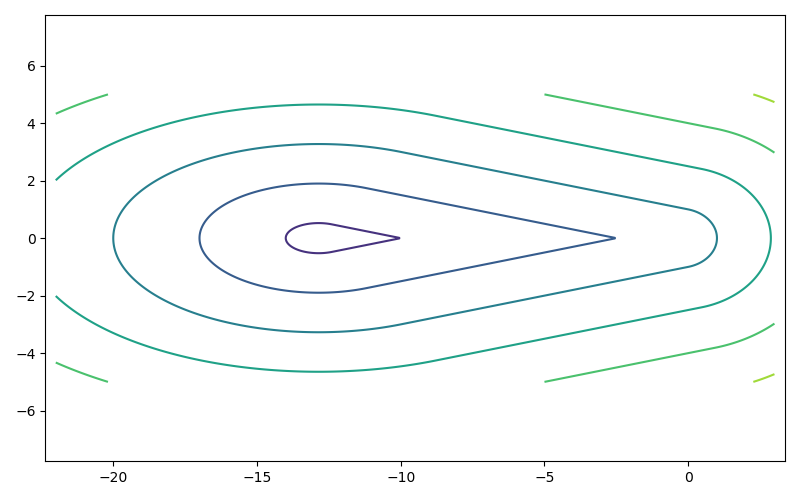

In [31]:
fig = plt.figure(figsize=(8, 5), tight_layout=True)
ax = fig.add_subplot(1, 1, 1) # , projection='3d')
ax.contour(sig_p_range, tau_p_range, f_f);
ax.axis('equal');

## **1.3 Flow potential**
For non-associative flow rule let us define an extension to be added to the threshold function 

In [32]:
S_NT = sp.sqrt(S_N*S_T)
c_NT = sp.sqrt(c_N*c_T)
r_NT = sp.sqrt(r_N*r_T)
omega_NT = 1 - sp.sqrt((1-omega_N)*(1-omega_T))
phi_N = (1 - omega_N)**c_N * S_N / (r_N+1) * (Y_N / S_N)**(r_N+1) 
phi_T = (1 - omega_T)**c_T * S_T / (r_T+1) * (Y_T / S_T)**(r_T+1) 
phi_NT = (1 - omega_NT)**c_NT * S_NT / (r_NT+1) * ((Y_N + Y_T)/(S_NT))**(r_NT+1)

In [33]:
phi_ext_ = ((1 - eta)*(phi_N + phi_T) + eta*phi_NT)
d_phi_ext_ = sp.simplify(phi_ext_.diff(Sig))

The flow potential $\varphi(\boldsymbol{\mathcal{E}}, \boldsymbol{\mathcal{S}})$ reads

In [34]:
phi_ = f_ + phi_ext_  # phi_T_ext + phi_N_ext

and the corresponding directions of flow given as a product of the sign operator $\Upsilon$ and of the derivatives with respect to state variables 
$\boldsymbol{\Upsilon} \, \partial_{\boldsymbol{\mathcal{S}}} \varphi$
This renders following flow direction vector
\begin{align}
\boldsymbol{\Phi} = - \Upsilon \frac{\partial \varphi}{\partial \boldsymbol{\mathcal{S}}} 
\end{align}

In [35]:
Phi_ = -Sig_signs * (f_.diff(Sig) + sp.simplify(phi_ext_.diff(Sig)))

**Executable code generation** $\boldsymbol{\Phi}(\boldsymbol{\mathcal{E}}, \boldsymbol{\mathcal{S})}$

In [36]:
get_Phi = sp.lambdify(
    (Eps, Sig) + sp_vars + ('**kw',), Phi_, numpy_dirac
)
get_Phi_C = ccode('get_Phi', Phi_, 'SLIDE1_3')

# **2 Time integration scheme**

## Discrete yield condition
In a continuous case we consistency condition to explicitly glue the state onto the yield surface 
\begin{align}
\dot{f}(\boldsymbol{\mathcal{S}}(s, \boldsymbol{\mathcal{E}(\lambda)}), \boldsymbol{\mathcal{E}(\lambda)} ) &= 0 \end{align}
In discrete case, we relax this requirement. Indeed, by taking $f(s_{n+1}; \boldsymbol{\mathcal{E}_n}) $ as a first trial value we can obtain positive values.

&nbsp;<font color="green">
**We allow for "trial" states which lie beyond the admissible domain $f \le 0$ during iteration. This allows us to construct a "return mapping" algorithm that iteratively approaches an admissible state on the yield surface.**</font>

Given an inadmissible trial state $k$ with the yield condition $f_k > 0$, let us introduce a linearized approximation of its change along the plastic multiplier $\lambda$ around the state $k$. 
\begin{align}
 f_{k+1} &= f_{k} + \left. \frac{\partial f}{\partial \lambda} \right|_k \Delta \lambda
\end{align}
In this form, we can search for an admissible state $f_{n+1} = 0$ by iterating over $k$.
Note that in initial iteration $k = 0$ the state from previous step is reused, i.e. 
$f(s_{n+1}; \boldsymbol{\mathcal{E}_n}) $.

In the linearized form, we can transform the yield condition to a recurrent formula
\begin{align}
\left. \frac{\mathrm{d} f}{\mathrm{d} \lambda}\right|_k \Delta \lambda &= -f_k,
\hspace{1cm} f_k \rightarrow 0 \; \;\mathrm{for}\;\; k = 1\ldots\infty
\end{align}
This resembles the Newton method for iterative solution of a nonlinear equation. However, we need to consider the fact that the level of inadmissibility $f$ changes between iterations. 
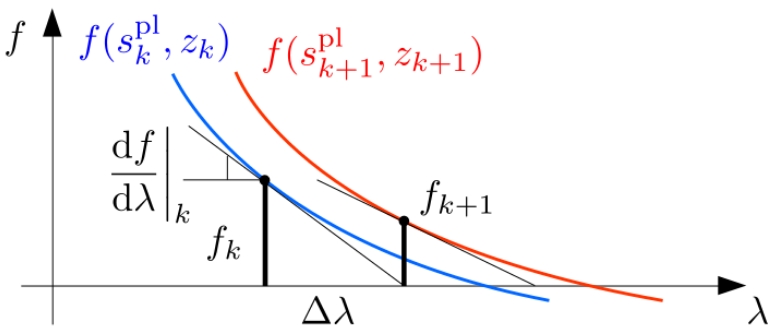
Note that the predictor is negative and $\Delta \lambda > 0$. In every step, the plastic multiplier is updated:
\begin{align}
\lambda_{k+1} &= \lambda_k + \Delta \lambda, \, \lambda_0 = 0 \nonumber \\ \nonumber
\end{align}

Two more questions must addressed to define a general numerical algorithm for plasticity:
<font color="brown">
 * **Update of state variables $\boldsymbol{\mathcal{E}}_{k+1}$ in each iteration**
 * **Expression of the predictor $\mathrm{d} f / \mathrm{d} \lambda$ in terms of the state variables**
</font>

## State update
In every iteration step the state variables $\boldsymbol{\mathcal{E}}$ must be updated using the discrete evolution equations, i.e. 
\begin{align}
\boldsymbol{\mathcal{E}}_{k+1} &= 
\boldsymbol{\mathcal{E}}_k + \lambda_{k+1} 
\boldsymbol{\Phi}_k
\label{eq:discrete_evolution}
\end{align}
Which is used in the calculation of the threshold function in the next step. Note that $\boldsymbol{\Phi}_k$ is evaluated in the state $k$ and not $k+1$.

To reach an admissible state let us linearize the threshold function at an interim state $k$ as
\begin{align}
f_{k+1} = 
f_k 
 +
\left.
\frac
{\partial f}
{\partial \lambda}
\right|_k
\Delta \lambda
\end{align}

## Predictor
\begin{align}
\left.
\frac{\partial f}{\partial{\lambda}}  
\right|_k 
&=
\left.
\frac{\partial f}{\partial{\boldsymbol{ \mathcal{E}}}}  
\right|_k 
\left.
\frac{\partial {\boldsymbol{ \mathcal{E}}}}{\partial \lambda}
\right|_k =
\left.
\frac{\partial f}{\partial{\boldsymbol{ \mathcal{E}}}}  
\right|_k 
\boldsymbol{\Phi}_k \\
\left.
\frac{\partial f}{\partial{\boldsymbol{ \mathcal{E}}}}  
\right|_k 
&=
\left. \frac{\partial f}{ \partial \boldsymbol{\mathcal{S}}}\right|_{k}
\left. \frac{\partial \boldsymbol{\mathcal{S}}}{\partial \boldsymbol{\mathcal{E}}}\right|_{k}
+
\left. \frac{\partial^{\mathrm{dir}} f}{ \partial^{\mathrm{dir}} \boldsymbol{\mathcal{E}}}\right|_{k}
\label{eq:df_dlambda}
\end{align}

**Remark 1:** The derivative $\partial^\mathrm{dir}$ denotes the direct derivative with respect to $\boldsymbol{\mathcal{E}}$

**Remark 2:** Note that $\displaystyle \frac{\partial \boldsymbol{\mathcal{E}}}{\partial \lambda}$ in equation $\eqref{eq:df_dlambda}$ can be obtained from the evolution equations $\eqref{eq:discrete_evolution}$
\begin{align}
\boldsymbol{\mathcal{E}}_k = \boldsymbol{\mathcal{E}}_n + \lambda \, \boldsymbol{\Phi}_k\; \implies
\left.
\frac{\partial {\boldsymbol{ \mathcal{E}}}}{\partial \lambda}
\right|_k = 
\boldsymbol{\Phi}_k
\end{align}

Thus, by rewriting the linearized equation as a recurrence formula, the iteration algorithm is obtained
\begin{align}
&
\left.
\frac{\partial f}{\partial{\lambda}}  
\right|_k 
\Delta \lambda
= - f^{(k)}\\
& \lambda_{k+1} = \lambda_{k} + \Delta \lambda \\
& \boldsymbol{\mathcal{E}}_{k+1} = \boldsymbol{\mathcal{E}}_{k} + 
 \lambda_{k} \, 
\frac{\partial {\boldsymbol{ \mathcal{E}}}}{\partial \lambda}
 \\
&k = k + 1
\end{align}

## Implementation concept
The gradient operators needed for the time-stepping scheme have been derived above and are now available for the implementation of the numerical algorithm both in `Python` and `C89` languages

<table style="width:50%">
<tr>
<th>Symbol</th>
<th>Python</th>
<th>C89</th>
</tr>
<tr>
<td>$\mathcal{S}(s, \boldsymbol{\mathcal{E}}) $  
</td>
<td>get_Sig</td>
<td>get_Sig_C</td>
</tr>
<tr>
<td>$\partial_\boldsymbol{\mathcal{E}}  \boldsymbol{\mathcal{S}}(s, \boldsymbol{\mathcal{E}}) $</td>
<td>get_dSig_dEps</td>
<td>get_dSig_dEps_C</td>
</tr>
<tr>
<td>$ f(\boldsymbol{\mathcal{S}}, \boldsymbol{\mathcal{E}})$</td>
<td>get_f</td>
<td>get_f_C</td>
</tr>
<tr>
<td>$\partial_\boldsymbol{\mathcal{S}} f(\boldsymbol{\mathcal{S}}, \boldsymbol{\mathcal{E}}) $  
</td>
<td>get_df_dSig</td>
<td>get_df_dSig_C</td>
</tr>
<tr>
<td>$\partial_\boldsymbol{\mathcal{E}} f(\boldsymbol{\mathcal{S}}, \boldsymbol{\mathcal{E}}) $</td>
<td>get_df_dEps</td>
<td>get_df_dEps_C</td>
</tr>
<tr>
<td>$\partial_\boldsymbol{\mathcal{S}} \varphi(\boldsymbol{\mathcal{S}}, \boldsymbol{\mathcal{E}}) $</td>
<td>get_Phi</td>
<td>get_Phi_C</td>
</tr>
</table>

**Threshold and its derivatives:** To avoid repeated calculation of the same expressions, let us put the evaluation of $f$ and $\partial_\lambda f$ into a single procedure. The iteration loop can be constructed in such a way that the predictor for the next step is calculated along with the residuum. In case that the residuum is below the required tolerance, the overhead for an extra calculated derivative is negligible or, with some care, can be even reused in the next time step.  

In [37]:
def get_f_df(u_Tx_n1, u_Ty_n1, u_N_n1, Sig_n, Eps_k, **kw):
    Sig_k = get_Sig(u_Tx_n1, u_Ty_n1, u_N_n1, Sig_n, Eps_k, **kw)[0]
    dSig_dEps_k = get_dSig_dEps(u_Tx_n1, u_Ty_n1, u_N_n1, Sig_n, Eps_k, **kw)
    f_k = np.array([get_f(Eps_k, Sig_k, **kw)])
    if f_k < -1e-1: # elastic step - should be fraction of current strength
        return f_k, np.array([[0]]), Sig_k
    df_dSig_k = get_df_dSig(Eps_k, Sig_k, **kw)
    ddf_dEps_k = get_ddf_dEps(Eps_k, Sig_k, **kw)
    df_dEps_k = np.einsum(
        'ik,ji->jk', df_dSig_k, dSig_dEps_k) + ddf_dEps_k
    Phi_k = get_Phi(Eps_k, Sig_k, **kw)
    dEps_dlambda_k = Phi_k
    df_dlambda = np.einsum(
        'ki,kj->ij', df_dEps_k, dEps_dlambda_k)
    df_k = df_dlambda
    return f_k, df_k, Sig_k

In [38]:
Eps_0 = np.zeros((len(Eps),), dtype=np.float_)
material_params = dict(
    E_T_=1, gamma_T_=1, K_T_=1, S_T_=1, c_T_=1, f_s_=1, 
    E_N_=1, gamma_N_=1, S_N_=0.5, c_N_=1, m_=0.05, f_t_=1, f_c_=-20, f_c0_=-10, r_N_=2, r_T_=2, eta_=0.1, zeta_=0, chi_=1
)
Sig_k = get_Sig(1.1, 0, 0, Eps_0, Eps_0, **material_params)

In [39]:
get_f_df(1.1, 0, 0, Eps_0, Eps_0, **material_params)

(array([0.1]),
 array([[-4.0025]]),
 array([ 1.1  , -0.   , -0.   ,  0.   ,  0.   ,  0.   ,  0.605,  0.   ]))

**Evolution equations:** The update of state variables for an updated $\lambda_k$ is performed using this procedure.

In [40]:
def get_Eps_k1(u_Tx_n1, u_Ty_n1, u_N_n1, Eps_n, lam_k, Sig_n, Eps_k, **kw):
    Sig_k = get_Sig(u_Tx_n1, u_Ty_n1, u_N_n1, Sig_n, Eps_k, **kw)[0]
    Phi_k = get_Phi(Eps_k, Sig_k, **kw)
    Eps_k1 = Eps_n + lam_k * Phi_k[:,0]
    return Eps_k1

**Return mapping iteration:** This function represents a user subroutine in a finite element code or in a lattice model. The input is $s_{n+1}$ and the state variables representing the state in the previous solved step $\boldsymbol{\mathcal{E}}_n$. The procedure returns the stresses and state variables of $\boldsymbol{\mathcal{S}}_{n+1}$ and $\boldsymbol{\mathcal{E}}_{n+1}$

In [41]:
def get_material_model(u_Tx_n1, u_Ty_n1, u_N_n1, Sig_n, Eps_n, k_max, **kw):
    Eps_k = np.copy(Eps_n)
    Sig_k = np.copy(Sig_n)
    lam_k = 0
    f_k, df_k, Sig_k = get_f_df(u_Tx_n1, u_Ty_n1, u_N_n1, Sig_k, Eps_k, **kw)
    f_k_norm = np.linalg.norm(f_k)
    f_k_trial = f_k[0]
    dlam = 0
    k = 0
    while k < k_max:
        if (f_k_trial < 0 or f_k_norm < 1e-3) and np.fabs(f_k_norm*dlam) < 1e-7:
            return Eps_k, Sig_k, k+1
        dlam = np.linalg.solve(df_k, -f_k)
        lam_k += dlam
        Eps_k = get_Eps_k1(u_Tx_n1, u_Ty_n1, u_N_n1, Eps_n, lam_k, Sig_k, Eps_k, **kw)
        f_k, df_k, Sig_k = get_f_df(u_Tx_n1, u_Ty_n1, u_N_n1, Sig_k, Eps_k, **kw)
        f_k_norm = np.linalg.norm(f_k)
        k += 1
    else:
        raise ValueError('no convergence')

In [42]:
Eps_0 = np.zeros((len(Eps),), dtype=np.float_)
material_params = dict(
    E_T_=1, gamma_T_=1, K_T_=1, S_T_=1, c_T_=1, f_s_=1, 
    E_N_=1, gamma_N_=1, S_N_=0.5, c_N_=1, m_=0.05, f_t_=1, f_c_=20, f_c0_=10, r_N_=1, r_T_=1, eta_=0, zeta_=0, chi_=1
)
get_material_model(0, 1.1, 0, Eps_0, Eps_0, 50, **material_params) 

(array([-0.00103943,  0.03419163,  0.00167843,  0.03356863,  0.03253311,
         0.03253311,  0.01871396,  0.        ]),
 array([ 1.01997919e-03,  1.04586287e+00, -1.67843133e-03,  3.35686266e-02,
         3.25331055e-02,  3.25331055e-02,  5.67974278e-01,  0.00000000e+00]),
 6)

**Loop over the time increments** for a single material point. This loop emulates the  finite-element spatial integration or a lattice-assembly algorithm.  

In [43]:
def get_response(u_max=[3,0,0], n_steps = 10, k_max=20, get_load_fn=lambda t: t, **kw):
    Eps_n1 = np.zeros((len(Eps),), dtype=np.float_)
    Sig_n1 = np.zeros_like(Eps_n1)
    Sig_record = []
    Eps_record = []
    iter_record = []
    t_arr = np.linspace(0,1,n_steps+1)
    u_Tx_max, u_Ty_max, u_N_max = u_max 
    u_Tx_t = u_Tx_max * get_load_fn(t_arr)# + 1e-9 # @todo: check the reason for 1e-9
    u_Ty_t = u_Ty_max * get_load_fn(t_arr)# + 1e-9
    u_N_t = u_N_max * get_load_fn(t_arr)# + 1e-9
    for u_Tx_n1, u_Ty_n1, u_N_n1 in zip(u_Tx_t, u_Ty_t, u_N_t):
        Eps_n1, Sig_n1, k = get_material_model(u_Tx_n1, u_Ty_n1, u_N_n1, Sig_n1, Eps_n1, k_max, **kw)
        Sig_record.append(Sig_n1)
        Eps_record.append(Eps_n1)
        iter_record.append(k)
    Sig_arr = np.array(Sig_record, dtype=np.float_)
    Eps_arr = np.array(Eps_record, dtype=np.float_)
    iter_arr = np.array(iter_record,dtype=np.int_)
    return t_arr, u_Tx_t, u_Ty_t, u_N_t, Eps_arr, Sig_arr, iter_arr

Test the `get_response` by imposing a proportional displacement load 
$\boldsymbol{u} = [1.1, 0, 0.1]$ mm. The calculation is performed in three steps. The dictionary of `material_params` is specified as follows.

In [44]:
material_params = dict(
    E_T_=1, gamma_T_=5, K_T_=5, S_T_=0.6, c_T_=1, f_s_=1, 
    E_N_=1, gamma_N_=1.0, S_N_=0.6, c_N_=1, m_=0.01, f_t_=1, f_c_=20, f_c0_=10, r_N_=1, r_T_=1, eta_=0.5, zeta_=0, chi_=1
)

In [45]:
t_arr, u_Tx_t, u_Ty_t, u_N_t, Eps_arr, Sigma_arr, iter_arr = get_response(
    u_max=[0,0,0.1], n_steps=3, k_max=50, **material_params
)

In [46]:
u_Tx_t

array([0., 0., 0., 0.])

In [47]:
iter_arr

array([1, 1, 1, 1])

# **3 Examples**

## **3.1 Support functions**
To run some examples, let us define some infrastructure including a more complex loading history and postprocessing

### Loading history
This implementation uses the symbolic machinery which is not necessary a simpler data point based implementation with `numpy.interp1d` would be better ... later 

Using matplotlib backend: module://ipympl.backend_nbagg


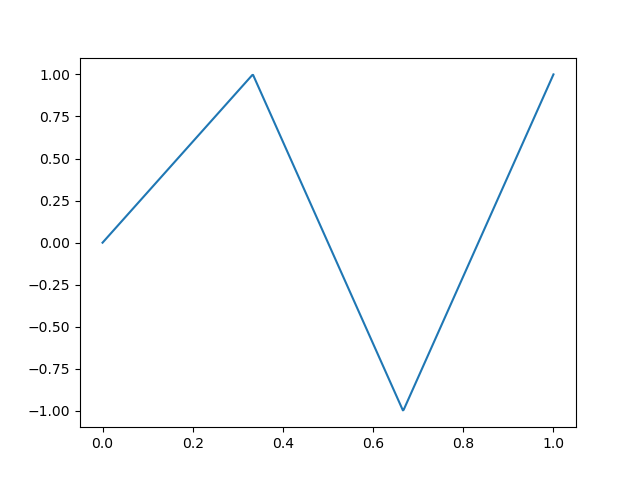

In [48]:
%matplotlib
t, theta = sp.symbols(r't, \theta')
n_cycles = 3
A = 2
ups = np.array([((theta-2*cycle)*A+(1-A), theta-2*cycle<=1) 
                for cycle in range(n_cycles)])
downs = np.array([((1-(theta-(2*cycle+1)))*A+(1-A),(theta-(2*cycle+1))<=1) 
                  for cycle in range(n_cycles)])
ups[0,0] = theta
updowns = np.einsum('ijk->jik',np.array([ups, downs])).reshape(-1,2)
load_fn = sp.Piecewise(*updowns).subs(theta,t*n_cycles)
get_load_fn = sp.lambdify(t, load_fn,'numpy')
t_arr = np.linspace(0,1,600)
plt.plot(t_arr, get_load_fn(t_arr));

### Plotting functions
To simplify postprocessing examples, here are two aggregate plotting functions, one for the state and force variables, the other one for the evaluation of energies

In [49]:
def plot_Sig_Eps(s_x_t, Sig_arr, Eps_arr, iter_arr, 
                 ax1, ax11, ax2, ax22, ax3, ax33, ax4, ax44):
    colors = ['blue','red', 'green', 'black', 'magenta' ]
    u_Tx_pi_, u_Ty_pi_, u_N_pi_, z_, alpha_Tx_, alpha_Ty_, omega_T_, omega_N_ = Eps_arr.T
    tau_x_pi_, tau_y_pi_, sig_pi_, Z_, X_x_, X_y_, Y_T_, Y_N_ = Sig_arr.T
    n_step = len(u_Tx_pi_)
    ax1.plot(s_x_t, tau_x_pi_, color='black', 
             label='n_steps = %g' % n_step)
    ax1.set_xlabel('$s$'); ax1.set_ylabel(r'$\tau$')
    ax1.legend()
    ax11.plot(s_x_t, iter_arr, '-.')
    ax2.plot(s_x_t, omega_T_, color='red', 
             label='n_steps = %g' % n_step)
    ax2.set_xlabel('$s$'); ax2.set_ylabel(r'$\omega$')
    ax2.plot(s_x_t, omega_N_, color='green', )
    ax22.plot(s_x_t, Y_T_, '-.', color='red', 
            label='n_steps = %g' % n_step)
    ax22.set_ylabel('$Y$')
    ax3.plot(s_x_t, z_, color='green', 
             label='n_steps = %g' % n_step)
    ax3.set_xlabel('$s$'); ax3.set_ylabel(r'$z$')
    ax33.plot(s_x_t, Z_, '-.', color='green')
    ax33.set_ylabel(r'$Z$')
    ax4.plot(s_x_t, alpha_Tx_, color='blue', 
             label='n_steps = %g' % n_step)
    ax4.set_xlabel('$s$'); ax4.set_ylabel(r'$\alpha$')
    ax44.plot(s_x_t, X_x_, '-.', color='blue')
    ax44.set_ylabel(r'$X$')

In [50]:
colors = dict( # color associations
    stored_energy = 'darkgreen', # recoverable
    free_energy_kin = 'darkcyan', # freedom - sky
    free_energy_iso = 'darkslateblue', # freedom - sky
    plastic_diss_s = 'darkorange', # fire - heat
    plastic_diss_w = 'red', # fire - heat
    damage_diss_s = 'darkgray', # ruined
    damage_diss_w = 'black'  # ruined
)

from scipy.integrate import cumtrapz
def plot_work(ax, t_arr, s_x_t, s_y_t, w_t, Eps_arr, Sig_arr):
    """Plot input work and stored energy on top of the dissipated energy.
    """
    W_arr = (
            cumtrapz(Sig_arr[:, 0], s_x_t, initial=0) +
            cumtrapz(Sig_arr[:, 1], s_y_t, initial=0) +
            cumtrapz(Sig_arr[:, 2], w_t, initial=0)
    )

    s_x_el_t = (s_x_t - Eps_arr[:, 0])
    s_y_el_t = (s_y_t - Eps_arr[:, 1])
    w_el_t = (w_t - Eps_arr[:, 2])
    U_arr = (
            Sig_arr[:, 0] * s_x_el_t / 2.0 +
            Sig_arr[:, 1] * s_y_el_t / 2.0 +
            Sig_arr[:, 2] * w_el_t / 2.0
    )
    G_arr = W_arr - U_arr
    ax.plot(t_arr, W_arr, lw=0.5, color='black', label=r'$W$ - Input work')
    ax.plot(t_arr, G_arr, '--', color='black', lw = 0.5, label=r'$W^\mathrm{inel}$ - Inelastic work')
    ax.fill_between(t_arr, W_arr, G_arr,
                    color=colors['stored_energy'], alpha=0.2)
    ax.set_xlabel('$t$ [-]');
    ax.set_ylabel(r'$E$ [Nmm]')
    ax.legend()
    
def plot_dissipation(ax, t_arr, Eps_arr, Sig_arr, ax_i=None):
    """Stapled and absolute plots of energy dissipation.
    """
    E_i = cumtrapz(Sig_arr, Eps_arr, initial=0, axis=0)
    E_T_x_pi_, E_T_y_pi_, E_N_pi_, E_z_, E_alpha_x_, E_alpha_y_, E_omega_T_, E_omega_N_ = E_i.T
    E_plastic_work_T = E_T_x_pi_ + E_T_y_pi_
    E_plastic_work_N = E_N_pi_
    E_plastic_work = E_plastic_work_T + E_plastic_work_N
    E_iso_free_energy = E_z_
    E_kin_free_energy = E_alpha_x_ + E_alpha_y_
    E_plastic_diss_T = E_plastic_work_T - E_iso_free_energy - E_kin_free_energy
    E_plastic_diss_N = E_plastic_work_N
    E_plastic_diss = E_plastic_diss_T + E_plastic_diss_N
    E_damage_diss = E_omega_T_ + E_omega_N_
    
    if not ax_i is None: 
        ax_i.plot(t_arr, E_damage_diss, color='gray', lw=2,
                  label=r'damage diss.: $Y\dot{\omega}$')
        ax_i.plot(t_arr, E_plastic_work, color='red', lw=2,
                  label=r'plastic work: $\sigma \dot{\varepsilon}^\pi$')
        ax_i.plot(t_arr, E_plastic_diss, color='red', lw=2, 
                  label=r'apparent pl. diss.: $\sigma \dot{\varepsilon}^\pi - X\dot{\alpha} - Z\dot{z}$')
        ax_i.plot(t_arr, -E_iso_free_energy, '-.', color='royalblue', lw=2,
                  label=r'iso. diss.: $Z\dot{z}$')
        ax_i.plot(t_arr, -E_kin_free_energy, '-.', color='blue', lw=2,
                  label=r'free energy: $X\dot{\alpha}$')
        ax_i.legend()
        ax_i.set_xlabel('$t$ [-]');
        ax_i.set_ylabel(r'$E$ [Nmm]')
        
    # stapled plot
    E_level = 0
    # E_damage_diss
    ax.plot(t_arr, E_damage_diss + E_level, color='black', lw=1)
    ax.fill_between(t_arr, E_omega_N_ + E_level, E_level, color='black',
                    hatch='|');
    E_d_level = E_level + E_omega_N_
    ax.fill_between(t_arr, E_omega_T_ + E_d_level, E_d_level, color='gray',
                    alpha=0.3);
    E_level = E_damage_diss
    # E_plastic_work:
    ax.plot(t_arr, E_plastic_work + E_level, lw=0.5, color='black')
    # ax.fill_between(self.t_arr, E_plastic_work + E_level, E_level, color='red', alpha=0.3)
    ax.fill_between(t_arr, E_plastic_work_N + E_level, E_level, color='orange',
                    alpha=0.3);
    E_p_level = E_level + E_plastic_work_N
    ax.fill_between(t_arr, E_plastic_work_T + E_p_level, E_p_level, color='red',
                    alpha=0.3);
    # E_plastic_diss:
    ax.plot(t_arr, E_plastic_diss + E_level, lw=.4, color='black')
    ax.fill_between(t_arr, E_plastic_diss_N + E_level, E_level, color='red',
                    hatch='-');
    E_d_level = E_level + E_plastic_diss_N
    ax.fill_between(t_arr, E_plastic_diss_T + E_d_level, E_d_level, color='red',
                    alpha=0.3);
    E_level += E_plastic_diss
    # E_iso_free_energy
    ax.plot(t_arr, E_iso_free_energy + E_level, '-.', lw=0.5, color='black')
    ax.fill_between(t_arr, E_iso_free_energy + E_level, E_level, color='royalblue',
                    hatch='|')
    E_level += E_iso_free_energy
    # E_kin_free_energy:
    ax.plot(t_arr, E_kin_free_energy + E_level, '-.', color='black', lw=0.5)
    ax.fill_between(t_arr, E_kin_free_energy + E_level, E_level, color='royalblue', alpha=0.2);
    
def plot_energy_breakdown(ax, ax_i, t_arr, s_x_t, s_y_t, w_t, Eps_arr, Sig_arr):
    """Plot the stapled and absolute breakdown of energies
    """
    plot_work(ax, t_arr, s_x_t, s_y_t, w_t, Eps_arr, Sig_arr)
    plot_dissipation(ax, t_arr, Eps_arr, Sig_arr, ax_i)

## **3.2 Interactive application**

To play around with the model, execute the cells below. Then, control displacements can be changed using the input sliders below. The corresponding response is recalculated immediately with 10 load increments inserted between the last and new displacement state. This implementation uses the package `ipywidgets` that includes interactive user widgets in into the jupyter notebook.

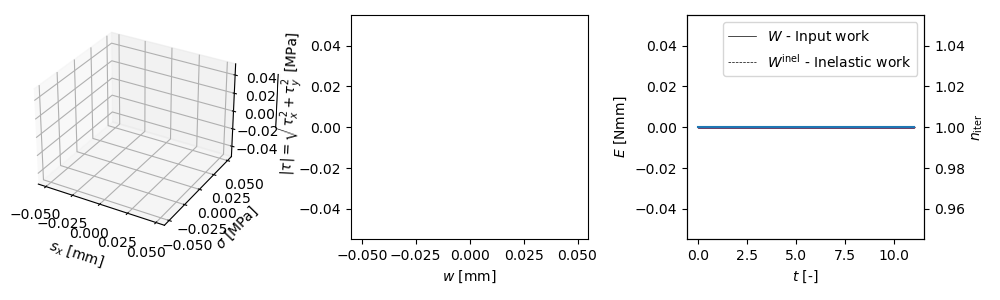

In [51]:
def init():
    '''Initialize the state variables'''
    global Eps_record, Sig_record, iter_record
    global t_arr, s_x_t, s_y_t, w_t, s_x_0, s_y_0, w_0, t0, Eps_n1, Sig_n1
    s_x_0, s_y_0 , w_0 = 0, 0, 0
    t0 = 0
    Sig_record = []
    Eps_record = []
    iter_record = []
    t_arr = []
    s_x_t, s_y_t, w_t = [], [], []
    Eps_n1 = np.zeros((len(Eps),), dtype=np.float_)
    Sig_n1 = np.zeros((len(Eps),), dtype=np.float_)

def get_response_i(s_x_1, s_y_1, w_1, n_steps = 10, k_max=300, **kw):
    '''Calculate the response for the next prescribed control displacement in n_steps'''
    global Eps_record, Sig_record, iter_record
    global t_arr, s_x_t, s_y_t, w_t, s_x_0, s_y_0, w_0, t0, Eps_n1, Sig_n1
    t1 = t0 + n_steps+1
    ti_arr = np.linspace(t0, t1, n_steps+1 )
    si_x_t = np.linspace(s_x_0,s_x_1,n_steps+1)
    si_y_t = np.linspace(s_y_0,s_y_1,n_steps+1)
    wi_t = np.linspace(w_0,w_1,n_steps+1)
    for s_x_n1, s_y_n1, w_n1 in zip(si_x_t, si_y_t, wi_t):
        Eps_n1, Sig_n1, k = get_material_model(s_x_n1, s_y_n1, w_n1, Sig_n1, Eps_n1, k_max, **kw)
        Sig_record.append(Sig_n1)
        Eps_record.append(Eps_n1)
        iter_record.append(k)
    t_arr = np.hstack([t_arr, ti_arr])
    s_x_t = np.hstack([s_x_t, si_x_t])
    s_y_t = np.hstack([s_y_t, si_y_t])
    w_t = np.hstack([w_t, wi_t])
    t0 = t1
    s_x_0, s_y_0, w_0 = s_x_1, s_y_1, w_1
    return

import ipywidgets as ipw

def plot3d_Sig_Eps(ax3d, s_x_t, s_y_t, Sig_arr, Eps_arr):
    tau_x, tau_y = Sig_arr.T[:2,...]
    tau = np.sqrt( tau_x**2 + tau_y**2 )
    ax3d.plot3D(s_x_t, s_y_t, tau, color='orange', lw=3)
    
def plot_sig_w(ax, w_t, Sig_arr, Eps_arr):
    sig_t = Sig_arr.T[2,...]
    ax.plot(w_t, sig_t, color='orange', lw=3)

fig = plt.figure(figsize=(10,3), tight_layout=True)
ax_tau = fig.add_subplot(1, 3, 1, projection='3d')
ax_sig = fig.add_subplot(1, 3, 2)
ax2 = fig.add_subplot(1, 3, 3)
ax_iter = ax2.twinx()
def update(s_x_1, s_y_1, w_1):
    global Eps_record, Sig_record, iter_record
    global t_arr, s_x_t, s_y_t, w_t, s_x_0, s_y_0, w_0, t0, Eps_n
    global kwargs
    get_response_i(s_x_1, s_y_1, w_1, **kwargs)
    Sig_arr = np.array(Sig_record, dtype=np.float_)
    Eps_arr = np.array(Eps_record, dtype=np.float_)
    iter_arr = np.array(iter_record,dtype=np.int_)
    ax_tau.clear()
    ax_sig.clear()
    ax2.clear()
    ax_iter.clear()
    plot3d_Sig_Eps(ax_tau, s_x_t, s_y_t, Sig_arr, Eps_arr)
    ax_tau.plot(s_x_t, s_y_t, 0, color='red')
    ax_tau.set_xlabel(r'$s_x$ [mm]');ax_tau.set_ylabel(r'$s_y$ [mm]');
    ax_tau.set_zlabel(r'$\| \tau \| = \sqrt{\tau_x^2 + \tau_y^2}$ [MPa]');

    plot_sig_w(ax_sig, w_t, Sig_arr, Eps_arr)
    ax_sig.set_xlabel(r'$w$ [mm]');ax_sig.set_ylabel(r'$\sigma$ [MPa]');

    plot_work(ax2, t_arr, s_x_t, s_y_t, w_t, Eps_arr, Sig_arr)
    plot_dissipation(ax2, t_arr, Eps_arr, Sig_arr)
    ax_iter.plot(t_arr, iter_arr)
    ax_iter.set_ylabel(r'$n_\mathrm{iter}$')

s_x_1_slider = ipw.FloatSlider(description='s_x',value=0,min=-4, max=+4, step=0.1,
                               continuous_update=False)
s_y_1_slider = ipw.FloatSlider(description='s_y',value=0,min=-4, max=+4, step=0.1,
                               continuous_update=False)
w_1_slider = ipw.FloatSlider(description='w', value=0,min=-4, max=+4, step=0.1,
                               continuous_update=False)

def reset(**kwargs_):
    global kwargs
    kwargs = kwargs_
    init()
    s_x_1_slider.value = 0
    s_y_1_slider.value = 0
    w_1_slider.value = 0

n_steps = 20

kwargs_ranges = [
    ('E_T_', 1, 0.5, 100),
    ('S_T_', 0.6, 0.00001, 100),
    ('c_T_', 1, 0.0001, 10),
    ('r_T_', 1, 0.001, 10),
    ('gamma_T_', 0, -20, 20),
    ('K_T_', 0, -20, 20),
    ('f_s_', 1, 0.5, 20),
    ('E_N_',1, 0.5, 100), 
    ('S_N_', 0.6, 0.0001, 100), 
    ('c_N_', 1, 0.0001,10), 
    ('m_', 0.1, 0.0001, 0.4), 
    ('r_N_', 1, 0.001, 10),
    ('gamma_N_', 0, -20, 20),
    ('f_t_', 1, 0.1, 10), 
    ('f_c_', 10, 1, 200), 
    ('f_c0_', 5, 1, 100), 
    ('eta_', 0, 0, 1),
]

kwargs = {key: val for (key, val, _, _) in kwargs_ranges}

kwargs_sliders = {
    name : ipw.FloatSlider(description=name, value=val, 
                            min=minval, max=maxval, step=(maxval-minval) / n_steps,
                           continuous_update=False)
    for name, val, minval, maxval in kwargs_ranges
}

slip_sliders = {'s_x_1': s_x_1_slider, 
                's_y_1': s_y_1_slider,
                'w_1': w_1_slider}

def slider_layout(out1, out2):
    layout = ipw.Layout(grid_template_columns='1fr 1fr')
    slider_list = tuple(kwargs_sliders.values())
    grid = ipw.GridBox(slider_list, layout=layout)
    slip_slider_list = tuple(slip_sliders.values())
    hbox = ipw.HBox(slip_slider_list)
    box = ipw.VBox([hbox, grid, out1, out2])
    display(box)
    
init()
out1 = ipw.interactive_output(update, slip_sliders)
out2 = ipw.interactive_output(reset, kwargs_sliders);
slider_layout(out1, out2)

## **3.3 Monotonic load**

The implemented model is executed using the function `get_response` with the parameters specifying the contol displacements. To verify the stability of the time-stepping scheme, the simulation is rung with different numbers of steps, i.e. 200 and 500.

In [52]:
E_T_x_ = 100
E_T_y_ = 100
u_T_0_ = 0.1
S_T_ = E_T_x_ * u_T_0_**2
material_params = dict(
    E_T_=10, gamma_T_=0, K_T_=0, S_T_=S_T_, c_T_=1, f_s_=2,
    E_N_=10, gamma_N_=0, S_N_=0.6, c_N_=1, m_=0.01, f_t_=2, f_c_=20, 
    f_c0_=10, r_N_=1, r_T_=1, eta_=0, zeta_=0
)

In [ ]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,5), tight_layout=True)
ax11 = ax1.twinx()
ax22 = ax2.twinx()
ax33 = ax3.twinx()
ax44 = ax4.twinx()
axes = ax1, ax11, ax2, ax22, ax3, ax33, ax4, ax44
for n_steps in [17, 20, 200]: # 20, 40, 200, 2000]:
    t_arr, s_x_t, s_y_t, w_t, Eps_arr, Sig_arr, iter_arr = get_response(
        u_max=[1, 0, 0.01], n_steps=n_steps, k_max=100, **material_params
    )
    plot_Sig_Eps(s_x_t, Sig_arr, Eps_arr, iter_arr, ax1, ax11, ax2, ax22, ax3, ax33, ax4, ax44)

In [ ]:
fig, (ax, ax2) = plt.subplots(1,2,figsize=(10, 5))
plot_energy_breakdown(ax, ax2, t_arr, s_x_t, s_y_t, w_t, Eps_arr, Sig_arr)

## **3.4 Cyclic loading**

In [ ]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6), tight_layout=True)
ax11 = ax1.twinx()
ax22 = ax2.twinx()
ax33 = ax3.twinx()
ax44 = ax4.twinx()
axes = ax1, ax11, ax2, ax22, ax3, ax33, ax4, ax44
t_arr, s_x_t, s_y_t, w_t, Eps_arr, Sig_arr, iter_arr = get_response(
    u_max=[3,0,0], n_steps=1000, k_max=100, get_load_fn=get_load_fn, **material_params
)
plot_Sig_Eps(s_x_t, Sig_arr, Eps_arr, iter_arr, ax1, ax11, ax2, ax22, ax3, ax33, ax4, ax44)

In [ ]:
fig, (ax, ax2) = plt.subplots(1,2,figsize=(10, 5))
plot_energy_breakdown(ax, ax2, t_arr, s_x_t, s_y_t, w_t, Eps_arr, Sig_arr)

# **4 Code generation**
See the docs for the code generation, the latexified  sympy symbols 
must be substituted such that they can act as standard C variable names.
The issue with this substitution might have been partially fixed by the substitution
code defined by this code.

The methods 
 * `get_f_df()`, and 
 * `get_Eps_n1` must be rewritten in C.
 
**How to transform `einsum` to C?**

The state arrays `Eps` and `Sig` must be prepared by the callee, i.e. the function to be 
called from at a level of material point in a finite-element or lattice code.
All the state variable matrices are flattened in the generated C code so that index access operators must be constructed with the correct convention, i.e. 
`i * n_row + j` or `i + n_col * j`. 

Let us consider the line
```Python
df_dEps_k = np.einsum('ik,ji->jk', df_dSig_k, dSig_dEps_k) + ddf_dEps_k
````

To transform this systematically into the C loop it is proposed define
index directives specifying the size of the first dimension. Then, the 
indexes from the `einsum` call can be systematically transferred to the 
multi-loop running over the indexes and respecting their order. No more 
thinking needed. The index operators below are prepared for arrays with 
2, 3, and 4 dimensions.
```C
#define IJ(N_I,I,J) (N_I * J + I)
#define IJK(N_I,N_J,I,J,K) (N_I * IJ(N_J,J,K) + I)
#define IJKL(N_I,N_J,N_K,I,J,K,L) (N_I * IJK(N_J,N_K,J,K,L) + I)
````
to perform the matrix multiplication
```C
int k=0;
for(int i=0;i<N_I;i++)
    for(int j=0;j<N_J;j++)
        df_dEps_1[IJ(N_J,j,k)] += df_dSig_k[IJ(N_I(i,k)] * dSig_dEps_k[IJ(N_J,j,i)]
    df_dEps[IJ(N_I,i,k)] = df_dEps_1[IJ(N_J,j,k)] + ddSig_dEps(IJ(N_I,i,k)];
````

The whole material model is represented by the material method
that mimics the internal par of the `get_response` function defined above

 1. Call `get_f_df()` to get the trial state
 2. Start the return mapping iteration loop
 3. If admissibility criterion fulfilled - admissible state found - return stress
 4. Evaluate delta of plastic multiplier and update it
 5. Update state variables using evolution equations `get_Eps_n1`
 6. Evaluate the residuum using `get_f_df()` and continuum with point 3.
 

In [ ]:
C_code = get_Sig_C, get_dSig_dEps_C, get_f_C, get_df_dSig_C, get_ddf_dEps_C, get_Phi_C 

In [ ]:
import os
import os.path as osp

code_dirname = 'sympy_codegen'
code_fname = 'SLIDE_3_4'

home_dir = osp.expanduser('~')
code_dir = osp.join(home_dir, code_dirname)
if not osp.exists(code_dir):
    os.makedirs(code_dir)

code_file = osp.join(code_dir, code_fname)

h_file = code_file + '.h'
c_file = code_file + '.c'
print(f'code_written to files {h_file} and {c_file}')

h_f = open(h_file,'w') 
c_f = open(c_file,'w')

if True:
    for function_C in C_code:
        h_f.write(function_C[1][1])
        c_f.write(function_C[0][1])
h_f.close()
c_f.close()

## Print the source code

Choose either `h_file` or `c_file` to see the generated code

In [ ]:
code_file = open(c_file, 'r')
print(code_file.read())